Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/bert_pretrained and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,Modelo,Accuracy,Tiempo_inferencia,Parámetros_entrenables,Parámetros_totales
0,Full Fine-Tuning,0.5,0.871513,109483778,109483778
1,LoRA Fine-Tuning,0.5,0.625583,0,109632772


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


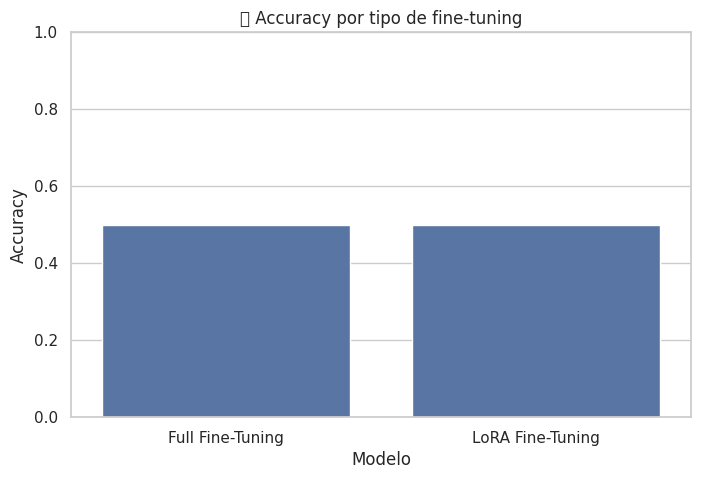

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


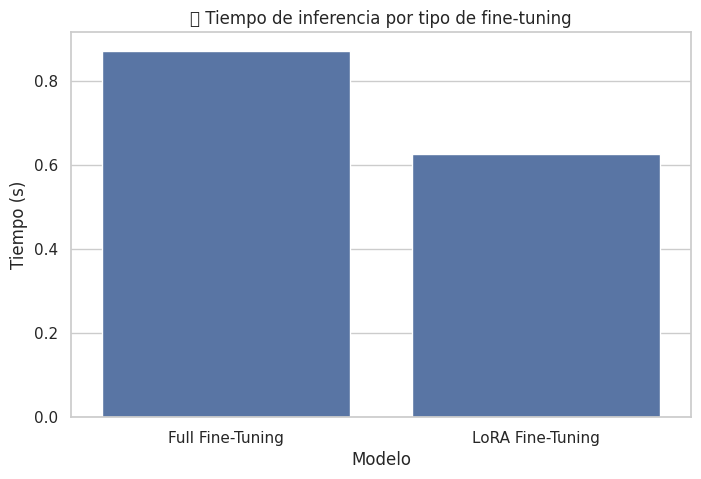

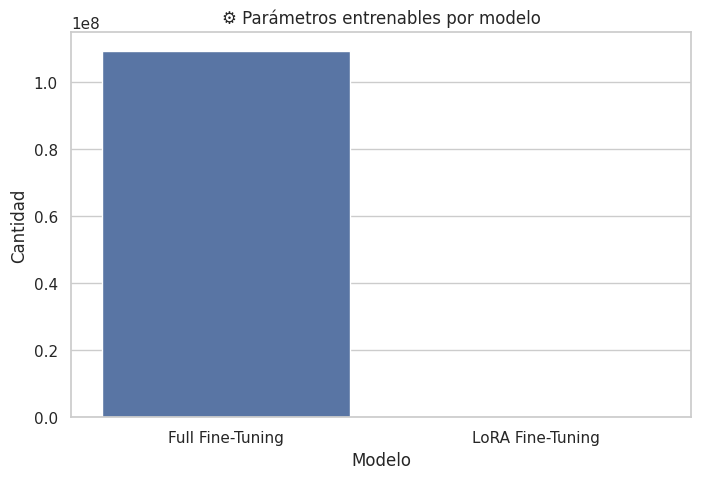

In [2]:
# .ipynb
# Objetivo: Comparar rendimiento de fine-tuning completo vs. LoRA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertForSequenceClassification, BertTokenizerFast
from peft import PeftModel
import torch
from time import time

#  Configuración
sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODELS = {
    "Full Fine-Tuning": "models/bert_finetuned_full",
    "LoRA Fine-Tuning": "models/bert_finetuned_lora"
}

frases = [
    "I love this movie, it was excellent!",
    "This is the worst experience I’ve ever had.",
    "The book was good, but not amazing.",
    "I hate the food, it made me sick.",
    "What a bad day!",
    "Absolutely fantastic performance!",
    "Terrible, just terrible.",
    "Not bad at all!",
    "I'm so happy today!",
    "This made me feel awful."
]

labels_reales = [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]  # Etiquetas esperadas

resultados = []

for nombre, path in MODELS.items():
    tokenizer = BertTokenizerFast.from_pretrained(path)
    model = BertForSequenceClassification.from_pretrained(path).to(device)
    model.eval()

    # Contar parámetros entrenables
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Evaluar accuracy
    predicciones = []
    start = time()
    for frase in frases:
        inputs = tokenizer(frase, return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            pred = torch.argmax(logits, dim=1).item()
        predicciones.append(pred)
    end = time()

    accuracy = sum([p == l for p, l in zip(predicciones, labels_reales)]) / len(labels_reales)

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy,
        "Tiempo_inferencia": end - start,
        "Parámetros_entrenables": trainable_params,
        "Parámetros_totales": total_params
    })

#  Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
display(df_resultados)

#  Accuracy vs Parámetros entrenables
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x="Modelo", y="Accuracy")
plt.title("📈 Accuracy por tipo de fine-tuning")
plt.ylim(0, 1.0)
plt.show()

#  Accuracy vs Tiempo
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x="Modelo", y="Tiempo_inferencia")
plt.title("⏱️ Tiempo de inferencia por tipo de fine-tuning")
plt.ylabel("Tiempo (s)")
plt.show()

#  Parámetros entrenables
plt.figure(figsize=(8, 5))
sns.barplot(data=df_resultados, x="Modelo", y="Parámetros_entrenables")
plt.title("⚙️ Parámetros entrenables por modelo")
plt.ylabel("Cantidad")
plt.show()
